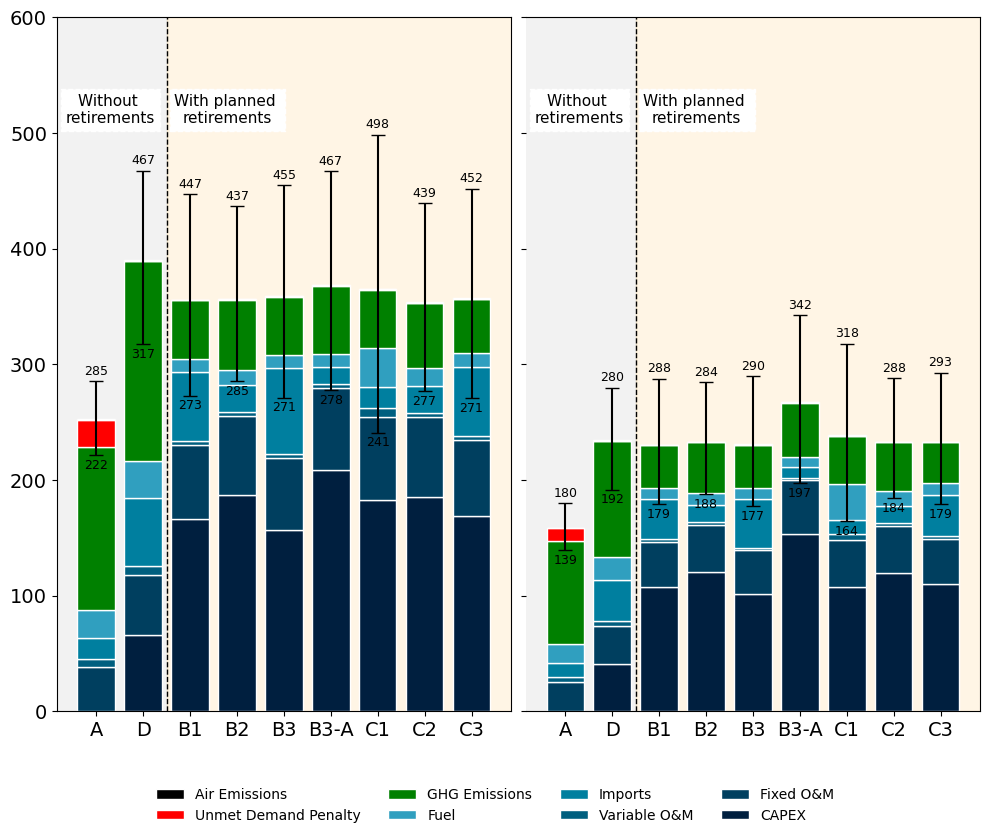

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV for each dataset
csv_path_dr3 = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/10 Total Costs Results Final/All_Costs_dr3.csv"
combined_ranges_dr3 = pd.read_csv(csv_path_dr3)

csv_path_dr7 = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/10 Total Costs Results Final/All_Costs_dr7.csv"
combined_ranges_dr7 = pd.read_csv(csv_path_dr7)

def format_cost(x):
    return f"{x:,.0f}"

# Define stacking order and colors
stacking_order = [
    'CAPEX', 'Fixed O&M', 'Variable O&M', 'Imports', 
    'Fuel', 'GHG Emissions', 'Unmet Demand Penalty', 'Air Emissions'
]

custom_colors = {
    'Air Emissions': 'black',
    'Unmet Demand Penalty': 'red',
    'GHG Emissions': 'green',
    'Fuel': '#309fbf',
    'Imports': '#007f9f',
    'Variable O&M': '#005f7f',
    'Fixed O&M': '#003f5f',
    'CAPEX': '#001f3f'
}
colors = [custom_colors[c] for c in stacking_order]


def plot_dataset(data, ax, title=None, show_rectangles=True):
    """
    Plots stacked bars + error bars for a single dataset on a given Axes object.
    """
    # 1) Aggregate costs
    total_costs = (
        data.groupby(['Pathway', 'Statistic'], as_index=False)
            .agg({'Cost_bUSD': 'sum'})
            .rename(columns={'Cost_bUSD': 'Total_Cost_bUSD'})
    )
    mean_costs = total_costs[total_costs['Statistic'] == 'mean']
    min_costs  = total_costs[total_costs['Statistic'] == 'min']
    max_costs  = total_costs[total_costs['Statistic'] == 'max']

    # 2) Pivot data for stacked bar
    stacked_data = (
        data[data['Statistic'] == 'mean']
        .pivot(index='Pathway', columns='Cost_Type', values='Cost_bUSD')
        .fillna(0)
    )
    # Reorder columns and optionally reorder index
    stacked_data = stacked_data[stacking_order]
    if "D" in stacked_data.index:
        stacked_data = stacked_data.loc[["D"] + [x for x in stacked_data.index if x != "D"]]
    if "A" in stacked_data.index:
        stacked_data = stacked_data.loc[["A"] + [x for x in stacked_data.index if x != "A"]]

    # 3) Plot stacked bars
    for i, col in enumerate(stacked_data.columns):
        bottom = stacked_data.iloc[:, :i].sum(axis=1) if i > 0 else 0
        ax.bar(
            stacked_data.index,
            stacked_data[col],
            bottom=bottom,
            label=col,
            color=colors[i],
            edgecolor="white"
        )

    # 4) Add vertical error bars + text for min/max
    offset = 3
    for pathway in stacked_data.index:
        ymin = min_costs.loc[min_costs['Pathway'] == pathway, 'Total_Cost_bUSD'].values[0]
        ymax = max_costs.loc[max_costs['Pathway'] == pathway, 'Total_Cost_bUSD'].values[0]
        mean_val = mean_costs.loc[mean_costs['Pathway'] == pathway, 'Total_Cost_bUSD'].values[0]
        
        ax.errorbar(
            x=pathway,
            y=mean_val,
            yerr=[[mean_val - ymin], [ymax - mean_val]],
            fmt='none',
            ecolor='black',
            capsize=5,
            zorder=5
        )
        ax.text(
            x=pathway,
            y=ymax + offset,
            s=format_cost(ymax),
            ha='center',
            va='bottom',
            fontsize=9
        )
        ax.text(
            x=pathway,
            y=ymin - offset,
            s=format_cost(ymin),
            ha='center',
            va='top',
            fontsize=9
        )

    # 5) Optionally add the rectangles & text
    #    (e.g., 'no retirements' & 'planned retirements')
    if show_rectangles:
        ax.axvline(x=1.5, color="black", linewidth=1, linestyle="--")
        ax.set_ylim(0, 600)

        rect_width = 3
        rect_height = 600
        rect_x = -0.5
        rect_y = 0
        # Gray rectangle
        ax.add_patch(
            plt.Rectangle(
                (rect_x-1, rect_y),
                rect_width,
                rect_height,
                color="gray",
                alpha=0.1,
                zorder=-1,
                edgecolor=None
            )
        )
        # Orange rectangle
        ax.add_patch(
            plt.Rectangle(
                (rect_x+2, rect_y),
                rect_width+5,
                rect_height,
                color="orange",
                alpha=0.1,
                zorder=-1,
                edgecolor=None
            )
        )
        ax.text(
            x=rect_x + rect_width - 2.2,
            y=rect_y + rect_height - 80,
            s="Without \nretirements",
            fontsize=11,
            ha='center',
            va='center',
            bbox=dict(
                boxstyle='square',
                edgecolor='white',
                linestyle='--',
                facecolor='white'
            )
        )
        ax.text(
            x=rect_x +3.3,
            y=rect_y + rect_height - 80,
            s="With planned \nretirements",
            fontsize=11,
            ha='center',
            va='center',
            bbox=dict(
                boxstyle='square',
                edgecolor='white',
                linestyle='--',
                facecolor='white'
            )
        )

    # 6) Title and style
    if title:
        ax.set_title(title, fontsize=14, pad=15)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)


# --- Create subplots with a shared y-axis ---
fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharey=True)

# Plot DR3 on the left
plot_dataset(combined_ranges_dr3, axes[0], show_rectangles=True)

# Plot DR7 on the right
# Optionally, remove rectangles for the second panel for a cleaner look:
plot_dataset(combined_ranges_dr7, axes[1], show_rectangles=True)

# Remove the second subplot's y-axis label/ticks/spine to create a "single y-axis" feel
axes[1].spines['left'].set_visible(False)
axes[1].tick_params(labelleft=False)

# Tighten layout / reduce the gap between subplots
plt.subplots_adjust(wspace=0)

# --- Create a single legend for the figure ---
handles, labels = axes[0].get_legend_handles_labels()
# Reverse so the legend order matches the stack order top-to-bottom
fig.legend(
    handles[::-1], labels[::-1],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),  # place at the bottom center
    ncol=4,                       # number of columns in the legend
    frameon=False,
    framealpha=0.9,
    fancybox=True
)

# Adjust layout so legend at bottom is not cut off
plt.tight_layout(rect=[0, 0.05, 1, 1])  
plt.savefig('Total_Costs_Comparison.svg', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/ty/d6vmlsnn34l60px2tgvgj2b80000gn/T/ipykernel_72734/348026941.py:190: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=12)
/var/folders/ty/d6vmlsnn34l60px2tgvgj2b80000gn/T/ipykernel_72734/348026941.py:190: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, fontsize=12)


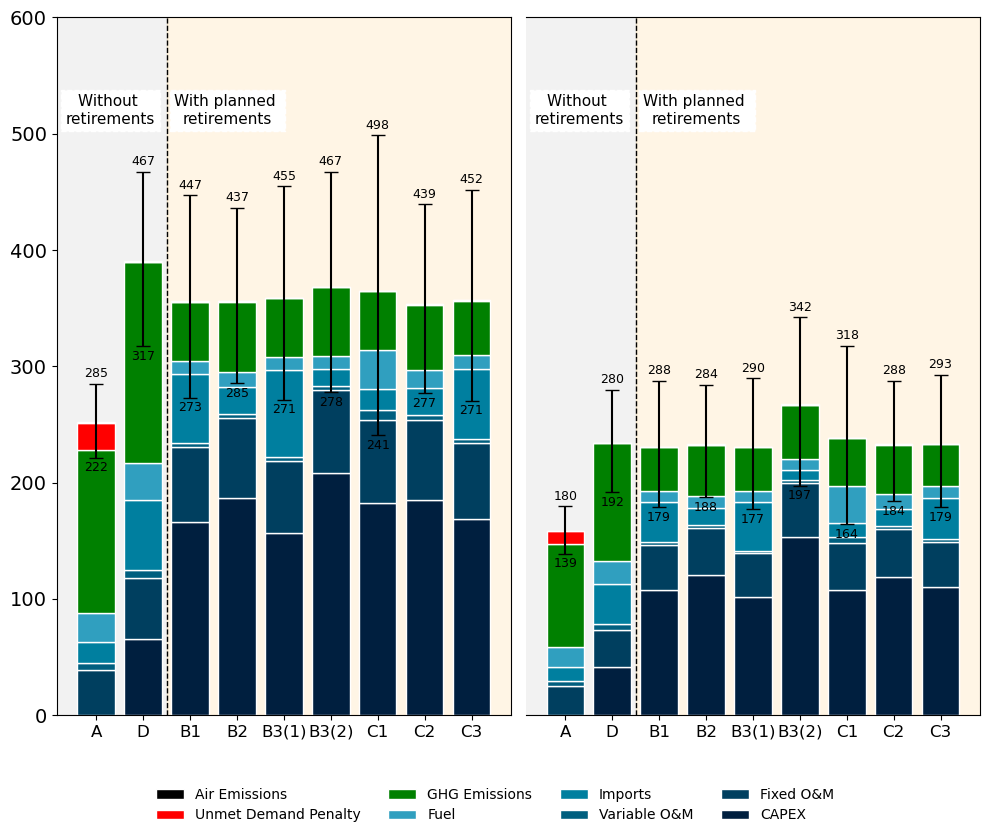

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load CSV for each dataset ---
csv_path_dr3 = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/10 Total Costs Results Final/All_Costs_dr3.csv"
combined_ranges_dr3 = pd.read_csv(csv_path_dr3)

csv_path_dr7 = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/3 Total Costs/10 Total Costs Results Final/All_Costs_dr7.csv"
combined_ranges_dr7 = pd.read_csv(csv_path_dr7)

def format_cost(x):
    """
    Helper function to format numbers (floats) with commas and no decimals.
    """
    return f"{x:,.0f}"

# --- Define stacking order and colors ---
stacking_order = [
    'CAPEX', 'Fixed O&M', 'Variable O&M', 'Imports', 
    'Fuel', 'GHG Emissions', 'Unmet Demand Penalty', 'Air Emissions'
]

custom_colors = {
    'Air Emissions': 'black',
    'Unmet Demand Penalty': 'red',
    'GHG Emissions': 'green',
    'Fuel': '#309fbf',
    'Imports': '#007f9f',
    'Variable O&M': '#005f7f',
    'Fixed O&M': '#003f5f',
    'CAPEX': '#001f3f'
}
colors = [custom_colors[c] for c in stacking_order]

def plot_dataset(data, ax, title=None, show_rectangles=True):
    """
    Plots stacked bars + error bars for a single dataset on a given Axes object.
    """
    # 1) Aggregate costs by Pathway & Statistic
    total_costs = (
        data.groupby(['Pathway', 'Statistic'], as_index=False)
            .agg({'Cost_bUSD': 'sum'})
            .rename(columns={'Cost_bUSD': 'Total_Cost_bUSD'})
    )
    mean_costs = total_costs[total_costs['Statistic'] == 'mean']
    min_costs  = total_costs[total_costs['Statistic'] == 'min']
    max_costs  = total_costs[total_costs['Statistic'] == 'max']

    # 2) Pivot data (only the 'mean' rows) for stacked bar
    stacked_data = (
        data[data['Statistic'] == 'mean']
        .pivot(index='Pathway', columns='Cost_Type', values='Cost_bUSD')
        .fillna(0)
    )
    # Reorder columns in the stacking order
    stacked_data = stacked_data[stacking_order]

    # Optionally reorder rows so certain pathways appear first
    if "D" in stacked_data.index:
        stacked_data = stacked_data.loc[["D"] + [x for x in stacked_data.index if x != "D"]]
    if "A" in stacked_data.index:
        stacked_data = stacked_data.loc[["A"] + [x for x in stacked_data.index if x != "A"]]

    # 3) Plot stacked bars
    for i, col in enumerate(stacked_data.columns):
        bottom_vals = stacked_data.iloc[:, :i].sum(axis=1) if i > 0 else 0
        ax.bar(
            stacked_data.index,
            stacked_data[col],
            bottom=bottom_vals,
            label=col,
            color=colors[i],
            edgecolor="white"
        )

    # 4) Add vertical error bars + text for min / max
    offset = 3
    for pathway in stacked_data.index:
        ymin = min_costs.loc[min_costs['Pathway'] == pathway, 'Total_Cost_bUSD'].values[0]
        ymax = max_costs.loc[max_costs['Pathway'] == pathway, 'Total_Cost_bUSD'].values[0]
        mean_val = mean_costs.loc[mean_costs['Pathway'] == pathway, 'Total_Cost_bUSD'].values[0]

        # Plot error bars
        ax.errorbar(
            x=pathway,
            y=mean_val,
            yerr=[[mean_val - ymin], [ymax - mean_val]],
            fmt='none',
            ecolor='black',
            capsize=5,
            zorder=5
        )
        # Label max value (above the top)
        ax.text(
            x=pathway,
            y=ymax + offset,
            s=format_cost(ymax),
            ha='center',
            va='bottom',
            fontsize=9
        )
        # Label min value (below the bottom)
        ax.text(
            x=pathway,
            y=ymin - offset,
            s=format_cost(ymin),
            ha='center',
            va='top',
            fontsize=9
        )

    # 5) Optionally add rectangles & text
    if show_rectangles:
        # Add dashed divider line
        ax.axvline(x=1.5, color="black", linewidth=1, linestyle="--")
        ax.set_ylim(0, 600)

        # We draw two large translucent rectangles
        rect_width = 3
        rect_height = 600
        rect_x = -0.5
        rect_y = 0

        # 1) Gray rectangle for "Without retirements"
        ax.add_patch(
            plt.Rectangle(
                (rect_x - 1, rect_y),
                rect_width,
                rect_height,
                color="gray",
                alpha=0.1,
                zorder=-1,
                edgecolor=None
            )
        )
        # 2) Orange rectangle for "With planned retirements"
        ax.add_patch(
            plt.Rectangle(
                (rect_x + 2, rect_y),
                rect_width + 5,
                rect_height,
                color="orange",
                alpha=0.1,
                zorder=-1,
                edgecolor=None
            )
        )
        # Annotations for the rectangles
        ax.text(
            x=rect_x + rect_width - 2.2,
            y=rect_y + rect_height - 80,
            s="Without \nretirements",
            fontsize=11,
            ha='center',
            va='center',
            bbox=dict(
                boxstyle='square',
                edgecolor='white',
                linestyle='--',
                facecolor='white'
            )
        )
        ax.text(
            x=rect_x + 3.3,
            y=rect_y + rect_height - 80,
            s="With planned \nretirements",
            fontsize=11,
            ha='center',
            va='center',
            bbox=dict(
                boxstyle='square',
                edgecolor='white',
                linestyle='--',
                facecolor='white'
            )
        )

    # 6) Title and style
    if title:
        ax.set_title(title, fontsize=14, pad=15)

    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # --- Rename x-axis tick labels for B1 and B1-A ---
    mapping = {"B3": "B3(1)", "B3-A": "B3(2)"}
    new_labels = [mapping.get(item, item) for item in stacked_data.index]
    ax.set_xticklabels(new_labels, fontsize=12)

# -------------------------------------------------------------------------
# Create subplots with a shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharey=True)

# Plot DR3 on the left
plot_dataset(combined_ranges_dr3, axes[0], show_rectangles=True)

# Plot DR7 on the right
plot_dataset(combined_ranges_dr7, axes[1], show_rectangles=True)

# Remove y-axis ticks & spine from right subplot to achieve a "single y-axis" look
axes[1].tick_params(axis='y', which='both', left=False, labelleft=False)
axes[1].spines['left'].set_visible(False)

# Tighten layout / reduce the gap between subplots
plt.subplots_adjust(wspace=0)

# --- Create a single legend for the figure ---
handles, labels = axes[0].get_legend_handles_labels()
# Reverse so the legend order matches the stack order top-to-bottom
fig.legend(
    handles[::-1],
    labels[::-1],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),  # place at the bottom center
    ncol=4,                       # number of columns in the legend
    frameon=False,
    framealpha=0.9,
    fancybox=True
)

# Adjust layout so the legend at bottom is not cut off
plt.tight_layout(rect=[0, 0.05, 1, 1])  
plt.savefig('Total_Costs_Comparison.svg', dpi=300, bbox_inches='tight')
plt.show()
